# Implementing Federated learning on CIFAR10 Dataset
---
#### Author: Ebinbin AJAGUN
#### 18th August 2019


It is important to note that this tutorials using Federated Learning (syft) on CIFAR10 adopts the code by openmined pysft examples and tries to implement the code on this Dataset since there are none of very scanty implementations of PySyft's Federated Learning implementation on CIFAR10 Dataset.
This is a hybrid merger of the Udacity CNN tutorial and Openmined syft Federated Learning tutorial.

![](images/cifar_data.png)

In [1]:
# import statements needed
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import syft as sy

import matplotlib.pyplot as plt
%matplotlib inline

torch.__version__

'1.1.0'

### Create Virtual Workers
Create the remote virtual workers to handle the distributed federated training.

In [2]:
hook = sy.TorchHook(torch)
# let's create two virtual workers who will hold the data while training the model locally
david = sy.VirtualWorker(hook, id = "david")
vanessa = sy.VirtualWorker(hook, id = "vanessa")

### Inpput Parameters
Here we place the hyperparamters the model will use during training

In [3]:
# set random seed manually for reproducability
# torch.manual_seed(42)

# Detect if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 
# This arguments class is simply defining all the hyperparameters of the model we are going to train on
class Arguments():
    def __init__(self):
        self.batch_size = 64 
        self.test_batch_size = 100 
        self.epochs = 10 
        self.lr = 0.01 
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 2222
        self.log_interval = 10
        self.save_model = False

args = Arguments()

### Preprocess and Load Data
This section downloads the CIFAR dataset, preprocesses the data and creates the federated and test data loaders.
Here data is converted to torch tensors and given to the Federated Dataloader before input into training. The Test data is left unchanged and is used to test the accuracy of the model after training. 

In [4]:
# define federated training data loader
fed_trainloader = sy.FederatedDataLoader(datasets.CIFAR10('data', train=True, download=True, 
                                                           transform=transforms.Compose([transforms.ToTensor(),
                                                                                         transforms.Normalize((0.5, 0.5, 0.5), 
                                                                                                              (0.5, 0.5, 0.5))])
                                                          ).federate((david, vanessa)), batch_size=args.batch_size, shuffle=True)


# define test data loader
test_loader = torch.utils.data.DataLoader(datasets.CIFAR10('data', train=False, download=True, 
                                                               transform=transforms.Compose([transforms.ToTensor(),
                                                                                             transforms.Normalize((0.5, 0.5, 0.5),
                                                                                                                  (0.5, 0.5, 0.5))])
                                                               ), batch_size=args.test_batch_size, shuffle=True)

# specify the image classes for the CIFAR10 Dataset
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


print('Number of Federated Training Images: ', len(fed_trainloader))
print('Number of Test Images: ', len(test_loader))

Files already downloaded and verified
Files already downloaded and verified
Number of Federated Training Images:  782
Number of Test Images:  100


### Define the Network Architecture
Here we define and build the Convolution Neural Network (CNN) architecture that will be used to train the model.<br>
The CNN archicture define here comprises  comprises 3 CNN layers and 2 fully connected layers with dropout layers between them.

In [5]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x


model = Net()
model


Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)

### Loss Function and Optimizer
Here we specify the loss and optimization function that is best suited and will be used for the classification task.

In [10]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss(reduction='sum')

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.003)

### Training & Test Functions
Here we define the training function for the network which involves aarranging the computational steps into layers of how the learnable parameters of the network should be computed and update the model during training.<br>
Likewise, the test function corrects for the differences in dropout training and testing stage.

In [11]:
# define the train helper function for training the model
def train(args, model, device, fed_trainloader, optimizer, epoch):

    model.train()
    
    for batch_idx, (data, target) in enumerate(fed_trainloader): # <-- now it is a distributed dataset
      
        model.send(data.location) # send the model to the workers location
        #data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        model.get() # <-- get the model back
        
        if batch_idx % args.log_interval == 0:
            loss = loss.get() # <-- NEW: get the loss back
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * args.batch_size, len(fed_trainloader) * args.batch_size, #batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(fed_trainloader), loss.item()))

In [12]:
# define the test helper function for evaluating the model
def test(args, model, device, test_loader):
  
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
          
            #data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Train the Network
Here we train the network across distributed virtual workers using the defined train functions which is the concept of Federated learning and use the test function to veritfy the accuracy of the trainied model.
And after each epoch we take an average and verify the loss and accuracy of the model using test data.

In [13]:
for epoch in range(1, args.epochs + 1):
    train(args, model, device, fed_trainloader, optimizer, epoch)
    test(args, model, device, test_loader)

Train Epoch: 1 [0/50048 (0%)]	Loss: 146.720901
Train Epoch: 1 [640/50048 (1%)]	Loss: 146.570557
Train Epoch: 1 [1280/50048 (3%)]	Loss: 144.578934
Train Epoch: 1 [1920/50048 (4%)]	Loss: 143.838638
Train Epoch: 1 [2560/50048 (5%)]	Loss: 142.364166
Train Epoch: 1 [3200/50048 (6%)]	Loss: 135.673431
Train Epoch: 1 [3840/50048 (8%)]	Loss: 134.150482
Train Epoch: 1 [4480/50048 (9%)]	Loss: 134.523621
Train Epoch: 1 [5120/50048 (10%)]	Loss: 132.853760
Train Epoch: 1 [5760/50048 (12%)]	Loss: 126.793854
Train Epoch: 1 [6400/50048 (13%)]	Loss: 128.151382
Train Epoch: 1 [7040/50048 (14%)]	Loss: 122.493996
Train Epoch: 1 [7680/50048 (15%)]	Loss: 129.494720
Train Epoch: 1 [8320/50048 (17%)]	Loss: 138.901382
Train Epoch: 1 [8960/50048 (18%)]	Loss: 122.273575
Train Epoch: 1 [9600/50048 (19%)]	Loss: 131.245926
Train Epoch: 1 [10240/50048 (20%)]	Loss: 119.069748
Train Epoch: 1 [10880/50048 (22%)]	Loss: 121.331642
Train Epoch: 1 [11520/50048 (23%)]	Loss: 116.453568
Train Epoch: 1 [12160/50048 (24%)]	Loss:

Train Epoch: 3 [0/50048 (0%)]	Loss: 68.665710
Train Epoch: 3 [640/50048 (1%)]	Loss: 62.156708
Train Epoch: 3 [1280/50048 (3%)]	Loss: 72.227180
Train Epoch: 3 [1920/50048 (4%)]	Loss: 67.105209
Train Epoch: 3 [2560/50048 (5%)]	Loss: 69.333313
Train Epoch: 3 [3200/50048 (6%)]	Loss: 67.403152
Train Epoch: 3 [3840/50048 (8%)]	Loss: 60.952572
Train Epoch: 3 [4480/50048 (9%)]	Loss: 64.303001
Train Epoch: 3 [5120/50048 (10%)]	Loss: 78.643547
Train Epoch: 3 [5760/50048 (12%)]	Loss: 61.399967
Train Epoch: 3 [6400/50048 (13%)]	Loss: 60.631630
Train Epoch: 3 [7040/50048 (14%)]	Loss: 62.336037
Train Epoch: 3 [7680/50048 (15%)]	Loss: 84.078995
Train Epoch: 3 [8320/50048 (17%)]	Loss: 78.676224
Train Epoch: 3 [8960/50048 (18%)]	Loss: 69.702599
Train Epoch: 3 [9600/50048 (19%)]	Loss: 62.867405
Train Epoch: 3 [10240/50048 (20%)]	Loss: 51.997730
Train Epoch: 3 [10880/50048 (22%)]	Loss: 44.180393
Train Epoch: 3 [11520/50048 (23%)]	Loss: 101.807541
Train Epoch: 3 [12160/50048 (24%)]	Loss: 66.069786
Train E

Train Epoch: 5 [640/50048 (1%)]	Loss: 60.383427
Train Epoch: 5 [1280/50048 (3%)]	Loss: 61.557198
Train Epoch: 5 [1920/50048 (4%)]	Loss: 74.552094
Train Epoch: 5 [2560/50048 (5%)]	Loss: 50.329277
Train Epoch: 5 [3200/50048 (6%)]	Loss: 50.395042
Train Epoch: 5 [3840/50048 (8%)]	Loss: 64.513832
Train Epoch: 5 [4480/50048 (9%)]	Loss: 60.358315
Train Epoch: 5 [5120/50048 (10%)]	Loss: 52.052452
Train Epoch: 5 [5760/50048 (12%)]	Loss: 63.612514
Train Epoch: 5 [6400/50048 (13%)]	Loss: 61.973026
Train Epoch: 5 [7040/50048 (14%)]	Loss: 47.632828
Train Epoch: 5 [7680/50048 (15%)]	Loss: 42.046722
Train Epoch: 5 [8320/50048 (17%)]	Loss: 52.664429
Train Epoch: 5 [8960/50048 (18%)]	Loss: 56.081009
Train Epoch: 5 [9600/50048 (19%)]	Loss: 56.093815
Train Epoch: 5 [10240/50048 (20%)]	Loss: 40.021645
Train Epoch: 5 [10880/50048 (22%)]	Loss: 52.713772
Train Epoch: 5 [11520/50048 (23%)]	Loss: 38.634277
Train Epoch: 5 [12160/50048 (24%)]	Loss: 59.218361
Train Epoch: 5 [12800/50048 (26%)]	Loss: 47.144131
Tra

Train Epoch: 7 [1280/50048 (3%)]	Loss: 62.454212
Train Epoch: 7 [1920/50048 (4%)]	Loss: 47.372852
Train Epoch: 7 [2560/50048 (5%)]	Loss: 59.451935
Train Epoch: 7 [3200/50048 (6%)]	Loss: 46.690422
Train Epoch: 7 [3840/50048 (8%)]	Loss: 36.734100
Train Epoch: 7 [4480/50048 (9%)]	Loss: 48.667545
Train Epoch: 7 [5120/50048 (10%)]	Loss: 55.304829
Train Epoch: 7 [5760/50048 (12%)]	Loss: 43.716110
Train Epoch: 7 [6400/50048 (13%)]	Loss: 56.265182
Train Epoch: 7 [7040/50048 (14%)]	Loss: 58.540615
Train Epoch: 7 [7680/50048 (15%)]	Loss: 65.634117
Train Epoch: 7 [8320/50048 (17%)]	Loss: 54.123478
Train Epoch: 7 [8960/50048 (18%)]	Loss: 46.956741
Train Epoch: 7 [9600/50048 (19%)]	Loss: 53.496197
Train Epoch: 7 [10240/50048 (20%)]	Loss: 56.225906
Train Epoch: 7 [10880/50048 (22%)]	Loss: 57.761635
Train Epoch: 7 [11520/50048 (23%)]	Loss: 46.693527
Train Epoch: 7 [12160/50048 (24%)]	Loss: 45.649960
Train Epoch: 7 [12800/50048 (26%)]	Loss: 48.253521
Train Epoch: 7 [13440/50048 (27%)]	Loss: 49.364407


Train Epoch: 9 [1920/50048 (4%)]	Loss: 43.404465
Train Epoch: 9 [2560/50048 (5%)]	Loss: 34.627918
Train Epoch: 9 [3200/50048 (6%)]	Loss: 32.209476
Train Epoch: 9 [3840/50048 (8%)]	Loss: 47.640209
Train Epoch: 9 [4480/50048 (9%)]	Loss: 47.396469
Train Epoch: 9 [5120/50048 (10%)]	Loss: 25.597790
Train Epoch: 9 [5760/50048 (12%)]	Loss: 57.730846
Train Epoch: 9 [6400/50048 (13%)]	Loss: 38.966072
Train Epoch: 9 [7040/50048 (14%)]	Loss: 49.328487
Train Epoch: 9 [7680/50048 (15%)]	Loss: 37.148457
Train Epoch: 9 [8320/50048 (17%)]	Loss: 45.614704
Train Epoch: 9 [8960/50048 (18%)]	Loss: 48.410908
Train Epoch: 9 [9600/50048 (19%)]	Loss: 59.688469
Train Epoch: 9 [10240/50048 (20%)]	Loss: 46.243301
Train Epoch: 9 [10880/50048 (22%)]	Loss: 41.891487
Train Epoch: 9 [11520/50048 (23%)]	Loss: 31.037430
Train Epoch: 9 [12160/50048 (24%)]	Loss: 50.363522
Train Epoch: 9 [12800/50048 (26%)]	Loss: 42.152321
Train Epoch: 9 [13440/50048 (27%)]	Loss: 57.544746
Train Epoch: 9 [14080/50048 (28%)]	Loss: 45.60395

### Evaluate the Trained Federated Network
Test the trained network to see how the faired overall to correctly predicting the classes of the CIFAR10 datasets.

In [18]:
batch_size = 20
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    data, target = data, target
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 78.419812

Test Accuracy of airplane: 85% (155/182)
Test Accuracy of automobile: 88% (179/202)
Test Accuracy of  bird: 60% (112/186)
Test Accuracy of   cat: 62% (132/210)
Test Accuracy of  deer: 75% (158/210)
Test Accuracy of   dog: 56% (109/192)
Test Accuracy of  frog: 77% (144/187)
Test Accuracy of horse: 80% (181/224)
Test Accuracy of  ship: 75% (153/202)
Test Accuracy of truck: 84% (174/205)

Test Accuracy (Overall): 74% (1497/2000)


### Visualize Sample Test Results
Visualize a batch of images used to test the model after training to see how they perform with the prediction.<br>
*****Note that class labels in red are wrong predictions while green class labels are correct predictions.**

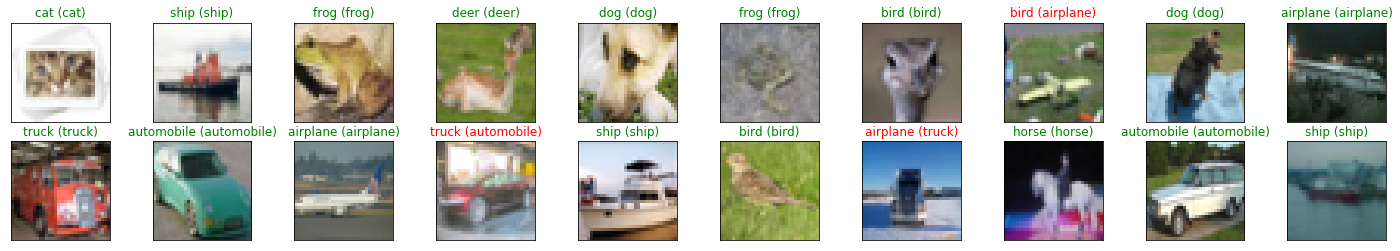

In [35]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
#if train_on_gpu:
#    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) 
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))